# Multi-class Classification and Neural Networks

# Introduction

In this exercise, a one-vs-all logistic regression and neural networks will be implemented to recognize hand-written digits (from 0 to 9).

# Multi-class Classification

Automated handwritten digit recognition is widely used today - from recognizing zip codes (postal codes) on mail envelopes to recognizing amounts written on bank checks. In the first part, the previous implementation of logistic regression will be extended and applied to one-vs-all classification.

## Dataset

The dataset in ex3data1.mat contains 5000 training examples of handwritten digits. The .mat format means that the data has been saved in a native Octave/MATLAB matrix format, instead of a text (ASCII) format like a csv-file. These matrices can be read by the `loadmat` module from `scipy`. After loading, matrices of the correct dimensions and values will appear in the program’s memory. The matrix will already be named, so there is no need to assign names to them.

There are 5000 training examples in ex3data1.mat, where each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. Each of these training examples becomes a single row in our data matrix X. This gives us a 5000 by 400 matrix X where every row is a training example for a handwritten digit image.

$X=\begin{bmatrix}
    -(x^{(1)})^T-\\
    -(x^{(2)})^T-\\
    \vdots\\
    -(x^{(m)})^T-
\end{bmatrix}$

The second part of the training set is a 5000-dimensional vector y that contains labels for the training set. **Note:** To make things more compatible with Octave/MATLAB indexing, where there is no zero index, the digit zero have been mapped to the value ten. Therefore, a “0” digit is labeled as “10”, while the digits “1” to “9” are labeled as “1” to “9” in their natural order.

In [1]:
import numpy as np 
from scipy.io import loadmat

data1 = loadmat('ex3data1.mat')
data1

{'X': array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 '__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 'y': array([[10],
        [10],
        [10],
        ..., 
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [2]:
X = data1['X']
y = data1['y']

print(X.shape, y.shape)

(5000, 400) (5000, 1)


## Visualizing the Data

Visualize a subset of the training set. The following code randomly selects 100 rows from X and passes those rows to the displayData function. This function maps each row to a 20 pixel by 20 pixel grayscale image and displays the images together.

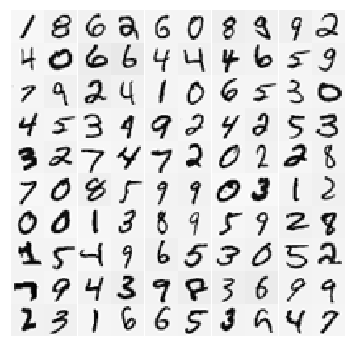

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

def displayData():
    """
    Select randomly 100 rows from X,
    plot them as 20x20 pixel grayscale images,
    and combine them to one figure with all
    100 digits.
    """
    # Create 100 subplots and remove the gaps
    # between the subplots with gridspec.
    fig, axarr = plt.subplots(10, 10,
                             figsize=(6, 6),
                             gridspec_kw={'wspace':0,
                                          'hspace':0})
    for i in range(10):
        for j in range(10):
            # Select random indices.
            idx = np.random.choice(len(X), 1)
            # Index the array X with the indices.
            pixels = X[idx] # shape(1, 400)
            pixels = pixels.reshape(-1, 20) # shape(20, 20)
            axarr[i,j].imshow(pixels.T, cmap='gray_r')
            # Remove ticks.
            axarr[i,j].set_xticks([])
            axarr[i,j].set_yticks([])
            # Turn off axes.
            axarr[i,j].axis('off')
    plt.show()

displayData()

## Vectorizing Logistic Regression

Multiple one-vs-all logistic regression models will be used to build a multi-class classifier. Since there are 10 classes, 10 separate logistic regression classifiers shall be trained. To make this training efficient, it is important to ensure that the code is well vectorized. A vectorized version of logistic regression that does not employ any for loops will be implemented.

### Vectorizing the Cost Function

Begin by writing a vectorized version of the cost function. Recall that in (unregularized) logistic regression, the cost function is

$J(\theta)=\frac{1}{m} \sum_{i=1}^m[-y^{(i)} log(h_\theta (x^{(i)})-(1-y^{(i)}) log(1-h_\theta (x^{(i)}))]$

To compute each element in the summation, we have to compute $h_{\theta}(x^{(i)})$ for every example $i$, where $h_{\theta}(x^{(i)})=g(\theta^{T}x^{(i)})$ and $g(z) = \frac{1}{1+e^{-z}}$ is the sigmoid function. It turns out that this can be computed quickly for all the examples by using matrix multiplication. If $X$ and $\theta$ are defined as

$X=\begin{bmatrix}
    -(x^{(1)})^T-\\
    -(x^{(2)})^T-\\
    \vdots\\
    -(x^{(m)})^T-
\end{bmatrix}$

and

$\theta=\begin{bmatrix}
    \theta_0\\
    \theta_1\\
    \vdots\\
    \theta_n
\end{bmatrix}$

then, by computing the matrix product $X\theta$, it gives

$X\theta=\begin{bmatrix}
    -(x^{(1)})^T\theta-\\
    -(x^{(2)})^T\theta-\\
    \vdots\\
    -(x^{(m)})^T\theta-
\end{bmatrix}=\begin{bmatrix}
    -\theta^T(x^{(1)})-\\
    -\theta^T(x^{(2)})-\\
    \vdots\\
    -\theta^T(x^{(m)})-
\end{bmatrix}$

In the last equality, the fact that $\alpha^Tb=b^T\alpha$ can be used since $\alpha$ and $b$ are vectors. This allows to compute the products $\theta^TX^{(i)}$ for all our examples $i$ in one line of code. A fully vectorized version should not contain any loops.

### Vectorizing the Gradient

Recall that the gradient of the (unregularized) logistic regression cost is a vector where the $j^{th}$ element is defined as

$\frac{\partial J}{\partial \theta_j}=\frac{1}{m} \sum_{i=1}^m(h_\theta(x^{(i)})-y^{(i)})x_j^{(i)}$

To vectorize this operation over the dataset, we start by writing out all the partial derivatives explicitly for all $\theta_j$,

$\begin{bmatrix}
    \frac{\partial J}{\partial \theta_0}\\
    \frac{\partial J}{\partial \theta_1}\\
    \frac{\partial J}{\partial \theta_2}\\
    \vdots\\
    \frac{\partial J}{\partial \theta_n}\\
\end{bmatrix}
    =\frac{1}{m}
\begin{bmatrix}
    \sum_{i=1}^m(h_\theta(x^{(i)})-y^{(i)})x_0^{(i)}\\
    \sum_{i=1}^m(h_\theta(x^{(i)})-y^{(i)})x_1^{(i)}\\
    \sum_{i=1}^m(h_\theta(x^{(i)})-y^{(i)})x_2^{(i)}\\
    \vdots\\
    \sum_{i=1}^m(h_\theta(x^{(i)})-y^{(i)})x_n^{(i)}\\
\end{bmatrix}=\frac{1}{m}X^T(h_{\theta}(x)-y)$

where

$h_{\theta}(x)-y=\begin{bmatrix}
    h_\theta(x^{(1)})-y^{(1)}\\
    h_\theta(x^{(2)})-y^{(2)}\\
    \vdots\\
    h_\theta(x^{(m)})-y^{(m)}\\
\end{bmatrix}$

Note that $x^{(i)}$ is a vector, while $h_\theta(x^{(i)})-y^{(i)}$ is a scalar (single number).

### Vectorizing Regularized Logistic Regression

The cost function for regularized logistic regression is defined as

$J(\theta)=\frac{1}{m} \sum_{i=1}^m[-y^{(i)} log(h_\theta (x^{(i)})-(1-y^{(i)}) log(1-h_\theta (x^{(i)}))]+\frac{\lambda}{2m} \sum_{j=1}^n\theta_j^2$

Note that the $\theta_0$ which is used for the bias term should not be regularized. Correspondingly, the partial derivative of regularized logistic regression cost for $\theta_j$ is defined as

$\frac{\partial J(\theta)}{\partial \theta_0}=\frac{1}{m} \sum_{i=1}^m(h_\theta(x^{(i)})-y^{(i)})x_j^{(i)}$ for $j=0$

$\frac{\partial J(\theta)}{\partial \theta_j}=\frac{1}{m} \sum_{i=1}^m(h_\theta(x^{(i)})-y^{(i)})x_j^{(i)}+\frac{\lambda}{m}\theta_j$ for $j\geq1$

Modify the code to account for regularization without any loops.

In [4]:
def sigmoid(z):
    """
    The sigmoid function.
    Args:
        z: float, vector, matrix
    Returns:
        sigmoid: float, vector, matrix
    """
    sigmoid = 1 / (1 + np.exp(-z))
    return sigmoid

def computeCost(theta, X, y, lambda_coef):
    """
    Compute the cost function.
    Args:
        theta: array shape(n+1, 1) 
        X: array shape(m, n+1) 
        y: array shape(m, 1)
        lambda_coef: int
    Returns:
        cost: float
    """
    m = X.shape[0]
    # Do matrix multiplication with numpy.dot
    h_theta = sigmoid(np.dot(X, theta))
    term1 = np.dot(-y.T, np.log(h_theta))
    term2 = np.dot((1 - y).T, np.log(1 - h_theta))
    # Exclude theta_0!!!
    reg_term = (lambda_coef / (2 * m)) * np.sum(np.square(theta[1:]))
    cost = (np.sum(term1 - term2) / m) + reg_term
    return cost

def computeGradient(theta, X, y, lambda_coef):
    """
    Compute the gradient.
    Args:
        theta: array shape(n+1, 1) 
        X: array shape(m, n+1) 
        y: array shape(m, 1)
        lambda_coef: int
    Returns:
        gradient: array shape(n+1, m)
    """
    m = X.shape[0]
    h_theta = sigmoid(np.dot(X, theta))
    # Exclude theta_0!!!
    reg_term = (lambda_coef / m) * (theta[1:])
    gradient = (1 / m) * np.dot(X.T, (h_theta - y))
    gradient[1:] = gradient[1:] + reg_term
    return gradient

## One-vs-all Classification

A one-vs-all classification will be implemented by training multiple regularized logistic regression classifiers, one for each of the $K$ classes in the dataset. In the handwritten digits dataset, $K=10$, but the code should work for any value of $K$.

The code should return all the classifier parameters in a matrix $\theta\in{R^{K\times(N+1)}}$ , where each row of $\theta$ corresponds to the learnt logistic regression parameters for one class. This can be done with a “for”-loop from $1$ to $K$, training each classifier independently.

Note that the $y$ argument to this function is a vector of labels from 1 to 10, where the digit “0” have been mapped to the label 10 (to avoid confusions with indexing).

When training the classifier for class $k\in{\{1,...,K\}}$, a m- dimensional vector of labels $y$ is desirable, where $y_j\in{0,1}$ indicates whether the $j^{th}$ training instance belongs to class $k$ $(y_j=1)$, or if it belongs to a different class $(y_j=0)$.

In [5]:
from scipy.optimize import minimize

def oneVsAll(X, y, K, lambda_coef):
    """
    Train K logisitc regression classifiers 
    and returns each of these classifiers
    in an array Thetas, where the i-th row
    corresponds to the classifier for label i.
    Args:
        X: array shape(m, n) 
        y: array shape(m, 1)
        K: int
        lambda_coef: int
    Returns:
        Thetas: array shape(K, n+1)
    """    
    # Get the number of training examples, m.
    m = X.shape[0]
    # Get the number of features, n.
    n = X.shape[1]

    # Create an array of shape(K, n+1) for each K class,
    # i.e. for each digit 0 to 9.
    Thetas = np.zeros((K, n+1))
    
    #Insert a 1's column to X.
    X = np.insert(X, 0, 1, axis=1)

    # Train each classifier independently from 1 to K.
    for i in range(0, K):
        print("Training the classifier for class k = {}...".format(i))
        # Take into account that class "10" corresponds to "0".
        if i == 0:
            x = 10
        else:
            x = i
        # Initialize theta.
        theta = np.zeros((n+1, 1))
        y_i = np.array([1 if class_k == x else 0 for class_k in y])
        y_i = np.reshape(y_i, (m, ))

        # Minimize the cost function.
        # Various methods were tested. It was found that 'TNC'
        # is faster and gives very good results.
        res = minimize(fun=computeCost, x0=theta, args=(X, y_i, lambda_coef),
                       method='TNC', jac=computeGradient)
        Thetas[i, :] = res.x
    print("Training is completed!")
    return Thetas

In [6]:
import warnings
warnings.filterwarnings('ignore')

Thetas = oneVsAll(X, y, 10, 0)

Training the classifier for class k = 0...
Training the classifier for class k = 1...
Training the classifier for class k = 2...
Training the classifier for class k = 3...
Training the classifier for class k = 4...
Training the classifier for class k = 5...
Training the classifier for class k = 6...
Training the classifier for class k = 7...
Training the classifier for class k = 8...
Training the classifier for class k = 9...
Training is completed!


### One-vs-all Prediction

After training the one-vs-all classifier, now it can be used to predict the digit contained in a given image. For each input, it should be computed the “probability” that it belongs to each class using the trained logistic regression classifiers. The one-vs-all prediction function will pick the class for which the corresponding logistic regression classifier outputs the highest probability and return the class label (1, 2,..., or K) as the prediction for the input example.

In [7]:
# Create a prediction function.
def predictOneVsAll(X, theta):
    """
    Predict whether the label is 0 or 1 using the
    learned logistic regression parameters Thetas.
    Probability "p" computes the predictions for X
    using a threshold at 0.5 i.e., if
    sigmoid(np.dot(X, theta.T)) >= 0.5, predict 1.
    "p" is set to a vector of predictions (from 1 to K).
    The numpy.argmax function returns the index of the
    max element.
    Args:
        X: array shape(m, n)
        theta: array shape(K, n+1), the optimal parameters
    Returns:
        p_argmax: list of "m" max p values
    """
    #Insert a 1's column to X.
    X = np.insert(X, 0, 1, axis=1) # shape(5000, 401)
    p = sigmoid(np.dot(X, theta.T)) # shape(5000, 10)
    p_argmax = np.argmax(p, axis=1) # shape(5000,)
    # Replace 0's with 10's to fix that a “0” digit is labeled as “10”.
    p_argmax = [10 if x == 0 else x for x in p_argmax]
    return p_argmax

predicted = predictOneVsAll(X, Thetas)
correct = np.sum(predicted == y.reshape(-1))
total = len(predicted)
print('Accuracy score: {}%'.format(100 * correct / total))

Accuracy score: 97.46%


# Neural Networks

In the previous part, a multi-class logistic regression was implemented to recognize handwritten digits. However, logistic regression cannot form more complex hypotheses as it is only a linear classifier. More features can be added (such as polynomial features) to logistic regression, but that can be very expensive to train.

In this part, a neural network will be implemented to recognize handwritten digits using the same training set as before. The neural network will be able to represent complex models that form non-linear hypotheses. This time, there will be used parameters from a neural network that have been already trained. The goal is to implement the feedforward propagation algorithm to use the weights for prediction. In a next work, the backpropagation algorithm will be created for learning the neural network parameters.

## Model Representation

The neural network that will be used has 3 layers - an input layer, a hidden layer and an output layer. Recall that the inputs are pixel values of digit images. Since the images are of size 20x20, this gives 400 input layer units (excluding the extra bias unit which always outputs +1). As before, the training data will be loaded into the variables X and y.

A set of already trained network parameters $(\Theta^{(1)}, \Theta^{(2)})$ are stored in `ex3weights.mat` and will be loaded by `loadmat` into `Theta1` and `Theta2`. The parameters have dimensions that are sized for a neural network with 25 units in the second layer and 10 output units (corresponding to the 10 digit classes).

## Feedforward Propagation and Prediction

Feedforward propagation will be implemented for the neural network. That will compute $h_\theta(x^{(i)})$ for every example $i$ and will return the associated predictions. Similar to the one-vs-all classification strategy, the prediction from the neural network will be the label that has the largest output $(h_\theta(x))_k$.

In [8]:
weights = loadmat('ex3weights.mat')

Theta1 = weights['Theta1']
Theta2 = weights['Theta2']

print("Shape of Theta1: ", Theta1.shape)
print("Shape of Theta2: ", Theta2.shape)

# Create a prediction function.
def predict(Theta1, Theta2, X):
    """
    Predict the label of an input given a trained neural network.
    Probability "p" outputs the predicted label of X given the
    trained weights of a neural network (Theta1, Theta2).
    "u" is the units in the second layer.
    Args:
        Theta1: array shape(u, n+1)
        Theta2: array shape(K, u+1)
        X: array shape(m, n)
    Returns:
        p_argmax: list of "m" max p values
    """
    #Insert a 1's column to X.
    X = np.insert(X, 0, 1, axis=1) # shape(5000, 401)
    a2 = sigmoid(np.dot(X, Theta1.T)) # shape(5000, 25)
    #Insert a 1's column to a2.
    a2 = np.insert(a2, 0, 1, axis=1) # shape(5000, 26)
    p = sigmoid(np.dot(a2, Theta2.T)) # shape(5000, 10)
    p_argmax = np.argmax(p, axis=1) # shape(5000,)
    # Add 1 to fix for zero indexed array.
    p_argmax = p_argmax + 1
    # Replace 0's with 10's to fix that a “0” digit is labeled as “10”.
    p_argmax = [10 if x == 0 else x for x in p_argmax]
    return p_argmax

predicted = predict(Theta1, Theta2, X)
correct = np.sum(predicted == y.reshape(-1))
total = len(predicted)
print('\nAccuracy score: {}%'.format(100 * correct / total))

Shape of Theta1:  (25, 401)
Shape of Theta2:  (10, 26)

Accuracy score: 97.52%
